## 0. Install dependencies

In [ ]:
!pip uninstall easyimages

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [4]:
od.download("https://www.kaggle.com/c/airbus-ship-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tymofiij
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 28.6G/28.6G [57:42<00:00, 8.86MB/s]



Extracting archive .\airbus-ship-detection/airbus-ship-detection.zip to .\airbus-ship-detection


## 1. Observe the data

In [3]:
data_path = './airbus-ship-detection/' # directory of the data
train_csv ='./airbus-ship-detection/train_ship_segmentations_v2.csv'  # Path to the CSV train file 
test_dir = data_path+'test_v2/' # Directory where the test images are currently located
train_dir = data_path+'train_v2/' # Directory where the train images are currently located

In [4]:
df = pd.read_csv(train_csv)     
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.1 Display image and segmentation

./airbus-ship-detection/train_v2/000155de5.jpg


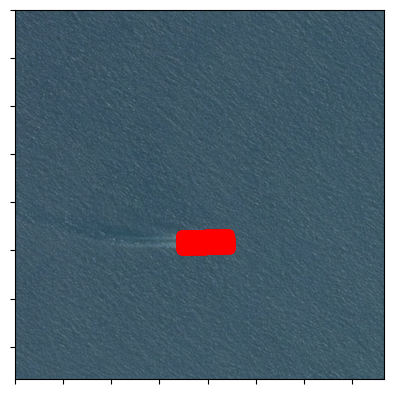

In [6]:
ship_coordinates = list(df.loc[2, 'EncodedPixels'].split())
ship_coordinates = [int(x) for x in ship_coordinates]
image_path = train_dir + df.loc[2, 'ImageId']
print(image_path)
image = Image.open(image_path)

pixel_number = np.array(ship_coordinates[::2])
pixel_amount = np.array(ship_coordinates[1::2])
pixel_numbers = []

for i in range(len(pixel_amount)):
    for j in range(pixel_number[i], pixel_number[i] + pixel_amount[i]):
        pixel_numbers.append(j)

pixel_numbers = np.array(pixel_numbers)

rows, cols = np.unravel_index(pixel_numbers - 1, image.size[:2])
plt.imshow(image)

plt.scatter(rows, cols, color='red', marker='o')

plt.tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
plt.show()

OSError: [WinError 1314] A required privilege is not held by the client: 'airbus-ship-detection\\train_v2\\00003e153.jpg' -> 'temp_link\\00003e153.jpg'